# Efficient Algorithms for Lasso Regression

In [82]:
%load_ext autoreload
%autoreload 2

import regression
import regression.data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import matplotlib.pyplot as plt
import numpy as np

In [84]:
optim = regression.SubGradientDescent()
model = regression.CompressiveLinearModel(np.random.normal(size=[200]))

In [85]:
(X, y) = regression.data.generate_dataset(200, 100, 10, noise_scale=0.01)

In [86]:
model(X)

array([ 2.75159880e-01,  2.06975347e+01,  3.82619284e+00,  1.43068647e+01,
        3.96721884e+00, -1.06010172e+01, -3.75994564e+00,  1.64967758e+00,
       -4.94980282e-01,  1.61755668e+01,  2.67721441e+00, -1.54128353e+01,
        1.32342528e+00,  7.57869635e-01, -8.81802587e+00, -8.00747656e+00,
        2.39401889e+01,  3.86812772e+00, -2.60298441e+00,  3.09532952e+00,
        2.55827660e+00,  1.18353067e+01, -1.40222400e+01,  1.53591039e+01,
        5.60290863e+00, -1.40425039e+01,  1.18204461e+01,  1.79781229e+00,
       -4.66780730e+00,  3.24725435e+01,  3.84244779e+00, -2.74780033e+01,
        9.40945774e+00,  4.06859899e+00, -2.06152185e+00,  8.72412717e+00,
        1.04057822e+01, -1.90067395e+00, -4.75801817e+00,  2.20903905e-02,
       -4.45081828e+00,  1.24362032e+01,  6.92673192e-01, -4.62068459e+00,
        3.37681416e+00,  1.75772814e+01, -1.28092710e+01,  2.30004991e+01,
        9.76154965e+00,  9.47855641e+00,  1.83135951e+00, -1.86245439e+00,
        7.80067539e+00, -

In [87]:
def l2(x_1: np.typing.NDArray[np.float64], x_2: np.typing.NDArray[np.float64]):
    return float(np.linalg.norm(x_2 - x_1))

In [88]:
metrics = regression.fit(model, optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})

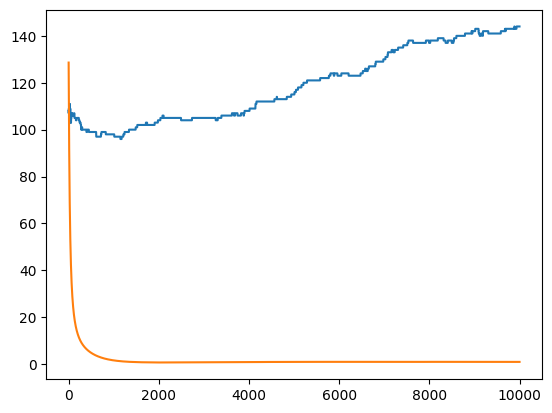

In [89]:
plt.plot(metrics["sparsity"])
plt.plot(metrics["l2"])
plt.show()

In [90]:
model(X)

array([-0.81332786, -2.23970898,  1.30430805, -5.87751713, -0.81084956,
       -2.7906569 , -2.0085595 , -0.73338742, -3.46685782,  9.26355573,
        2.4960178 ,  0.24482101, -0.36022806, -1.80885839, -5.57301162,
       -3.72203903, -5.24473862, -2.30032401, -1.92059548, -1.44085399,
        0.68655873, -3.32091518, -4.74731543,  0.38018385, -1.174233  ,
        2.48293234,  0.28371507, -3.99623649, -1.76172534,  2.96917753,
       -0.50589545,  0.89497468, -0.09182292, -0.61366456, -0.01425017,
        1.42896791,  1.54338029,  0.56161036,  1.34269762,  1.94766539,
        2.043882  , -0.74513951, -5.60218563, -3.6368974 ,  5.20201468,
        2.45364799,  0.46115031, -3.95060957,  2.35518025, -0.12088532,
       -3.74387037,  2.73086554,  1.99506991,  4.56727654, -4.83065187,
       -0.9502866 ,  0.61092746, -0.39256757,  2.87593769, -3.4508336 ,
       -2.39036392,  1.44115539, -8.24632321, -2.28909645,  1.51726436,
        2.64030935,  3.37589816, -0.62741526,  2.8358131 , -1.02

In [91]:
y

array([-0.84278313, -2.19674969,  1.24346975, -5.87316083, -0.77301471,
       -2.96293619, -2.19348762, -0.68300464, -3.5107084 ,  9.43269047,
        2.53818721,  0.29950769, -0.33547271, -1.88858397, -5.64250876,
       -3.79213948, -5.41348014, -2.30491559, -1.79323851, -1.42434895,
        0.71350853, -3.38546433, -4.87651745,  0.41791365, -1.32850765,
        2.56598171,  0.14011012, -3.99292512, -1.66291332,  3.01629927,
       -0.3876255 ,  0.73823801,  0.03911521, -0.64302541, -0.01935868,
        1.58960542,  1.61590138,  0.51319618,  1.51355041,  1.95539893,
        2.06168219, -0.68539275, -5.65963505, -3.60302875,  5.27813171,
        2.5931582 ,  0.50169801, -4.09565725,  2.3122551 , -0.13077396,
       -3.73280687,  2.87507686,  1.91636215,  4.66586162, -4.8081752 ,
       -0.91626831,  0.75658191, -0.41250915,  2.87227759, -3.46038148,
       -2.41678123,  1.3813387 , -8.32101877, -2.44990067,  1.42600412,
        2.57961171,  3.38544881, -0.59162068,  2.84161544, -0.93